In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylib.style as pys
import os.path

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Получаю данные
радпоправки нужно пересчитывать сразу для всех сезонов

In [127]:
SEASONS = ['11', '12', '17', '19', '20']

In [128]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           (df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

In [199]:
df = pd.concat([get_cs(season) for season in SEASONS], axis=0)

In [200]:
df.drop(list(df.columns[[i.startswith('y') for i in df.columns]]) + ['dy_exp', 'dy_exp_err'], axis=1, inplace=True)

Определяю проблемные точки, пока удаляю их, но нужно присмотреться

In [201]:
df.loc[np.any(df.isna(), axis=1)].head()

,n_sig_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,n_sig_exp_err,m_exp_err,sL_exp_err,sR_exp_err,...,eff_trig_err,lum,lum_err,dccorr,dccorr_err,rad,rad_err,cs_born,cs_born_err,season
537.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,558.26400,1.188240,NaN,NaN,1.0,0.0,NaN,NaN,11
960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,566.39400,2.154990,NaN,NaN,1.0,0.0,NaN,NaN,12
509.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,183.35400,0.603001,NaN,NaN,1.0,0.0,NaN,NaN,17
512.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.32151,0.050142,NaN,NaN,1.0,0.0,NaN,NaN,17
516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00000,0.000000,NaN,NaN,1.0,0.0,NaN,NaN,17


In [202]:
df.dropna(inplace=True)

## Определить поправки

In [203]:
from pylib.csapprox import MDVM
from iminuit import Minuit, cost
mdvm = MDVM()

In [204]:
df_koz = pd.read_csv('../data/other/kskl_kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born', 'cs_err': 'cs_born_err'}, axis=1)
df_koz['emeas'] /= 2

In [205]:
df_rad = pd.concat([df_koz, df])

In [206]:
params = [0.9639, 1.0919, -0.0062, -0.0279, 1.0509, 
          -0.0674, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 
          150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 
          225.0, 2239.0, 139.0, 1.3856, 0.0064, -0.2363, 0.01]

In [207]:
m = Minuit(cost.LeastSquares(df_rad.emeas*2e-3, 
        df_rad.cs_born, df_rad.cs_born_err, lambda x, n, r1, r2, r3, p1, p2, mr3, wr3, mo2, wo2, mp1, wp1, mo3, wo3, mr1, wr1, mo1, wo1, mp2, wp2, a20, a21, a22, a23: 
        mdvm.Cross_Section_Neutral(x, [n, r1, r2, r3, p1, p2, mr3, wr3, mo2, wo2, mp1, wp1, mo3, wo3, mr1, wr1, mo1, wo1, mp2, wp2, a20, a21, a22, a23])), *params)

In [208]:
m.fixed['mr3'], m.fixed['wr3'] = True, True
m.fixed['mo2'], m.fixed['wo2'] = True, True
m.fixed['mp1'], m.fixed['wp1'] = True, True
m.fixed['mo3'], m.fixed['wo3'] = True, True
m.fixed['mr1'], m.fixed['wr1'] = True, True
m.fixed['mo1'], m.fixed['wo1'] = True, True
m.fixed['mp2'], m.fixed['wp2'] = True, True

In [213]:
m.simplex()#.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 164                        │             Nfcn = 4119              │
│ EDM = 0.088 (Goal: 0.1)          │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │  1.3705   │  0.0020   │            │            │         │         │       │
│ 1 │ r1   │  0.5311   │  0.0023   │            │            │         │         │       │
│ 2 │ r2   │  -0.1967  │  0.0010   │            │            │         │         │       │
│ 3 │ r3   │  0.0416   │  0.0020   │            │            │         │         │       │
│ 4 │ p1   │  0.7470   │  0.0011   │            │            │         │         │       │
│ 5 │ p2   │  -0.1120  │  0.0011   │            │            │         │         │       │
│ 6 │ mr3  │  1.740e3  │  0.017e3  │            │            │         │         │  yes  │
│ 7 │ wr3  │   250.0   │    2.5    │            │            │         │         │  yes  │
│ 8 │ mo2  │  1.670e3  │  0.017e3  │            │            │         │         │  yes  │
│ 9 │ wo2  │   315.0   │    3.2    │            │            │         │         │  yes  │
│ 10│ mp1  │  1.680e3  │  0.017e3  │            │            │         │         │  yes  │
│ 11│ wp1  │   150.0   │    1.5    │            │            │         │         │  yes  │
│ 12│ mo3  │  2.150e3  │  0.021e3  │            │            │         │         │  yes  │
│ 13│ wo3  │   315.0   │    3.2    │            │            │         │         │  yes  │
│ 14│ mr1  │  1.470e3  │  0.015e3  │            │            │         │         │  yes  │
│ 15│ wr1  │    400    │     4     │            │            │         │         │  yes  │
│ 16│ mo1  │  1.425e3  │  0.014e3  │            │            │         │         │  yes  │
│ 17│ wo1  │   225.0   │    2.3    │            │            │         │         │  yes  │
│ 18│ mp2  │  2.239e3  │  0.022e3  │            │            │         │         │  yes  │
│ 19│ wp2  │   139.0   │    1.4    │            │            │         │         │  yes  │
│ 20│ a20  │  -0.034   │   0.009   │            │            │         │         │       │
│ 21│ a21  │  -0.320   │   0.005   │            │            │         │         │       │
│ 22│ a22  │   0.325   │   0.007   │            │            │         │         │       │
│ 23│ a23  │   1.85    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [214]:
params = m.values

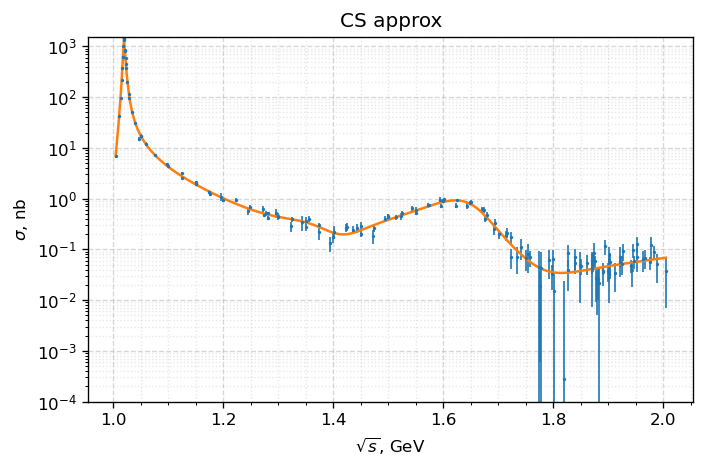

In [215]:
xx = np.linspace(df_rad.emeas.min()*2e-3, df_rad.emeas.max()*2e-3, 200)
yy = mdvm.Cross_Section_Neutral(xx, m.values)

plt.figure(dpi=120)
plt.errorbar(df_rad.emeas*2e-3, df_rad.cs_born, yerr=df_rad.cs_born_err, fmt='.', label=f'Measured cs', alpha=1, markersize=2, lw=1)
plt.plot(xx, yy)
pys.my_style(title='CS approx', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb',
            ylim=(1e-4, None))
plt.yscale('log')

In [216]:
df_fit = pd.DataFrame({'emeas': xx, 'cs_born': yy})

In [217]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [218]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [219]:
df_cutted = df_rad.dropna().reset_index().set_index(['season', 'index']).copy()
for index, j in df_cutted.iterrows():
    rad, rad_err = r.F_Radcor(index[1], j[['mu', 's', 'c', 'N']])/RegEff.sigFunc(0, *j[['mu', 's', 'c', 'N']])
    df_cutted.at[index, 'rad_new'], df_cutted.at[index, 'rad_new_err'] = rad, rad_err

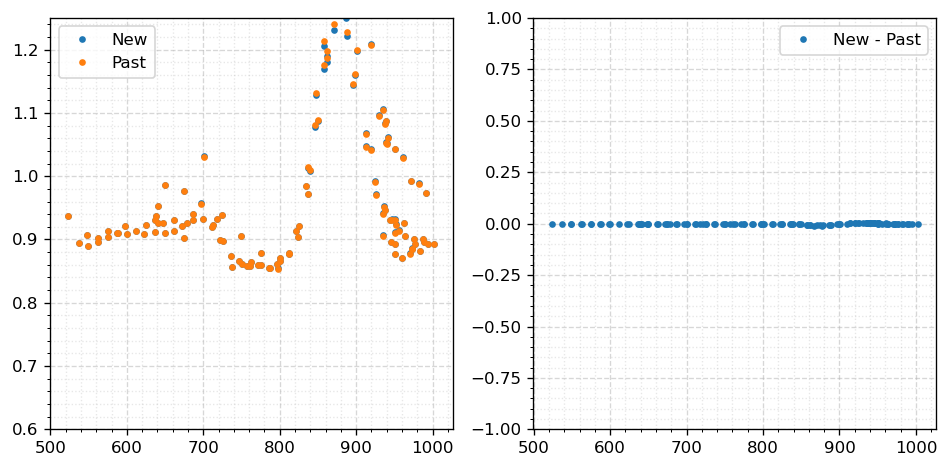

In [220]:
plt.figure(dpi=120, figsize=(8, 4))
plt.subplot(121)
plt.errorbar(df_cutted.emeas, df_cutted.rad_new, fmt='.', label='New')
plt.errorbar(df_cutted.emeas, df_cutted.rad, fmt='.', label='Past')
plt.legend()
pys.my_style()
plt.ylim(0.6, 1.25);
plt.subplot(122)
plt.errorbar(df_cutted.emeas, (df_cutted.rad_new - df_cutted.rad)/df_cutted.rad, fmt='.', label='New - Past')
plt.legend()
plt.ylim(-1, 1)
pys.my_style()

In [221]:
for season, table in df_cutted.groupby('season'):
    tab = table.reset_index().set_index('index')[['rad_new', 'rad_new_err']].\
        rename({'rad_new': 'rad', 'rad_new_err': 'rad_err'}, axis=1)
    tab.index = tab.index.rename('')
    tab.to_csv(f'../data/{season}/results/radcors.csv')

## Рисовать сечения

In [222]:
crosses = {
    '11': get_cs('11'),
    '12': get_cs('12'),
    '17': get_cs('17'),
    '19': get_cs('19'),
    '20': get_cs('20'),
}

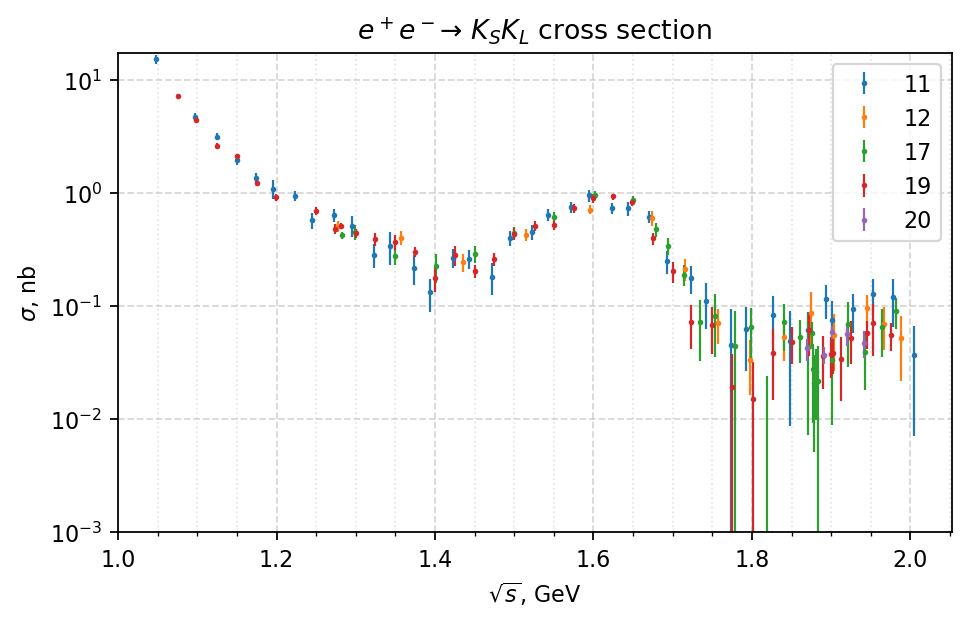

In [224]:
# plt.figure(dpi=160)

fig, ax = plt.subplots(dpi=160)
for cs in crosses:
    ax.errorbar(crosses[cs].emeas*2e-3, crosses[cs].cs_born, yerr=crosses[cs].cs_born_err, fmt='.', label=cs, ms=3, lw=1)
pys.my_style(title='$e^+e^- \\to \ K_SK_L$ cross section', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb', ylim=(1e-3, None), legend=True)
ax.set_yscale('symlog', linthresh=1e-3)
# fig.savefig('cs.png', dpi=300)